## Part 2: Finding data and making maps in Python

After you run the cell below, please click __Runtime > Restart Runtime__ to avoid plotting errors.

In [ ]:
!pip install pygris[explore] matplotlib --upgrade

Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '085' for input 'Richmond'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'


<Axes: >

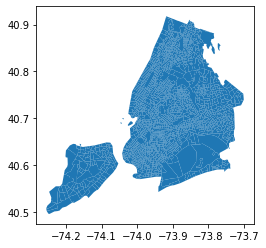

In [1]:
from pygris import tracts

nyc_counties = ["New York", "Bronx", "Richmond", 
                "Kings", "Queens"]

nyc_tracts = tracts(state = "NY", county = nyc_counties, cb = True,
                    year = 2021, cache = True)

nyc_tracts.plot()

In [2]:
from pygris.data import get_census

ny_college = get_census(dataset = "acs/acs5/profile",
                        variables = "DP02_0068PE",
                        year = 2021,
                        params = {
                          "for": "tract:*",
                          "in": "state:36"},
                        guess_dtypes = True,
                        return_geoid = True)

<Axes: >

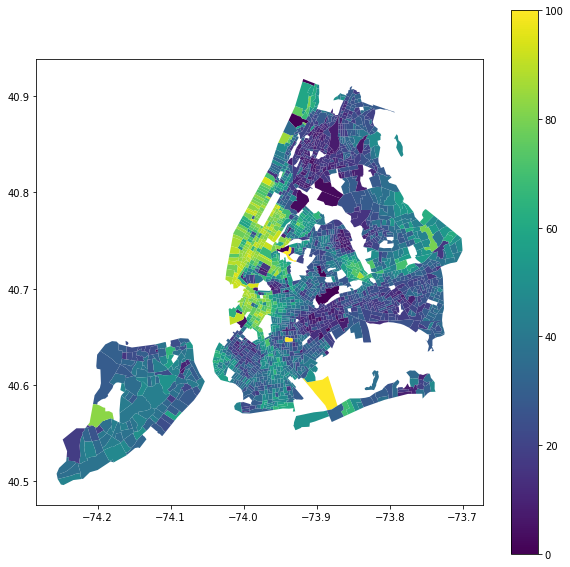

In [3]:
nyc_merged = nyc_tracts.merge(ny_college, how = "inner", on = "GEOID")

nyc_merged.plot(column = "DP02_0068PE", legend = True, figsize = (10, 10))

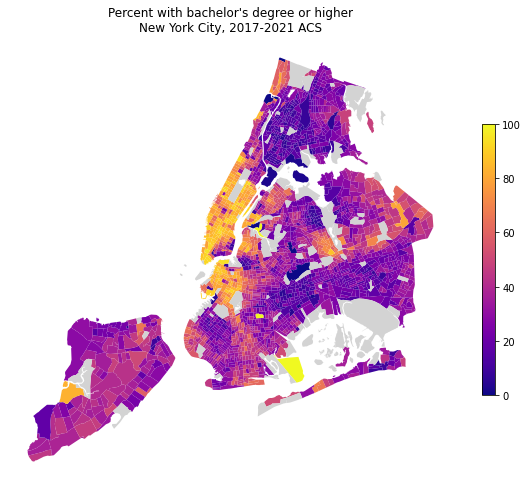

In [4]:
from pygris.utils import erase_water

import matplotlib.pyplot as plt

nyc_erase = erase_water(nyc_merged, area_threshold = 0.9)

nyc_erase.plot(column = "DP02_0068PE", legend = True,
               figsize = (10, 10), cmap = "plasma",
               legend_kwds = dict(shrink = 0.5),
               missing_kwds = dict(color = "lightgrey"))

plt.title("Percent with bachelor's degree or higher\nNew York City, 2017-2021 ACS")

ax = plt.gca()

ax.set_axis_off()

In [5]:
nyc_erase.explore(column = "DP02_0068PE")


In [6]:
nyc_subset = nyc_erase.filter(["GEOID", "DP02_0068PE", "geometry"])

nyc_subset.explore(column = "DP02_0068PE", cmap = "plasma",
                   tooltip = False, popup = True,
                   tiles = "CartoDB positron",
                   style_kwds = dict(weight = 0.5, nan_fill_color = "lightgrey"),
                   popup_kwds = dict(aliases = ["Census tract", "Percent"]),
                   legend_kwds = dict(caption = "Percent age 25+ with bachelor's degree"))

<Axes: >

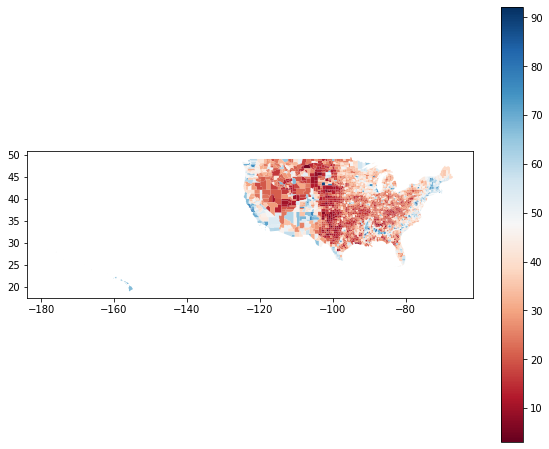

In [7]:
from pygris import counties
import pandas as pd

results2020 = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv",
                          dtype = {"county_fips": "object"})

results2020['per_dem'] = results2020['per_dem'] * 100

us_counties = counties(cb = True, year = 2020)

us_election = us_counties.merge(results2020, left_on = "GEOID", right_on = "county_fips")

us_election.plot("per_dem", cmap = "RdBu", legend = True, figsize = (10, 8))

In [8]:
from pygris import state_legislative_districts

ak_districts = state_legislative_districts("AK", cb = True, house = "lower", year = 2020)

# We remove Alaska counties from the counties dataset, then align the columns of our data
us_counties_noak = us_counties.query('GEOID != "02"').filter(['GEOID', 'geometry'])
ak_geoid_only = ak_districts.filter(['GEOID', 'geometry'])

# In the election file, Alaska districts start with "029" instead of "020"
ak_geoid_only['GEOID'] = ak_geoid_only['GEOID'].str.replace('020', '029', n = 1)

# Combine spatial datasets with pd.concat()
us_election_counties = pd.concat([us_counties_noak, ak_geoid_only])

Using FIPS code '02' for input 'AK'


<Axes: >

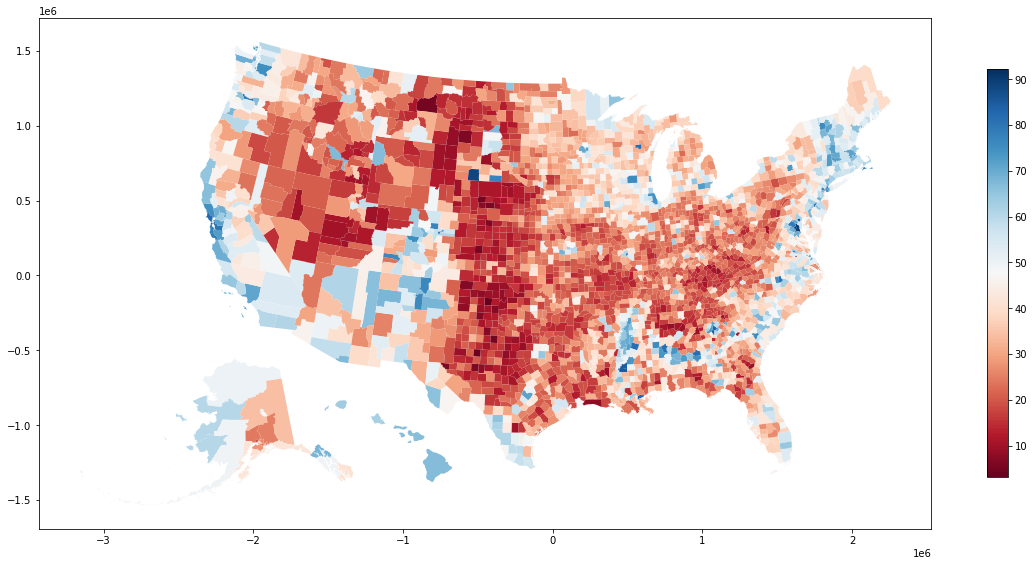

In [9]:
from pygris.utils import shift_geometry

us_election_geo = us_election_counties.merge(results2020, left_on = "GEOID", 
                                             right_on = "county_fips")

us_election_shift = shift_geometry(us_election_geo)

us_election_shift.plot(column = "per_dem", cmap = "RdBu", legend = True, figsize = (20, 15),
                       linewidth = 0.1, legend_kwds = {"shrink": 0.5})

<Axes: >

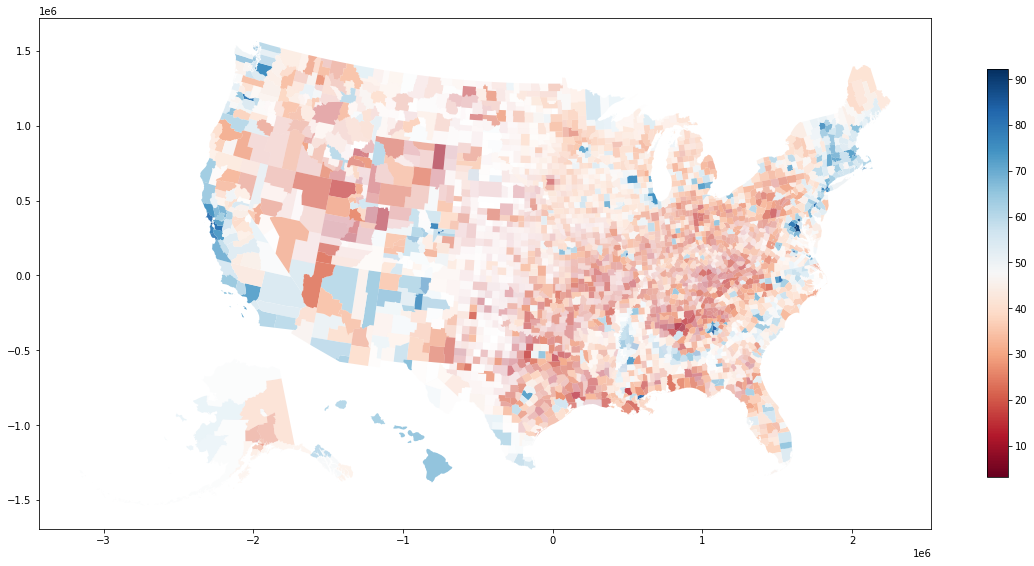

In [10]:
us_election_shift['percentile'] = us_election_shift['total_votes'].rank(pct = True)

us_election_shift.plot(column = "per_dem", cmap = "RdBu", legend = True, figsize = (20, 15),
                       legend_kwds = {"shrink": 0.5}, alpha = us_election_shift['percentile'],
                       linewidth = 0.1)

Text(0.5, 1.0, '2020 Presidential Election Results by County\nValues represent % voting for President Biden; circle sizes relative to total votes cast')

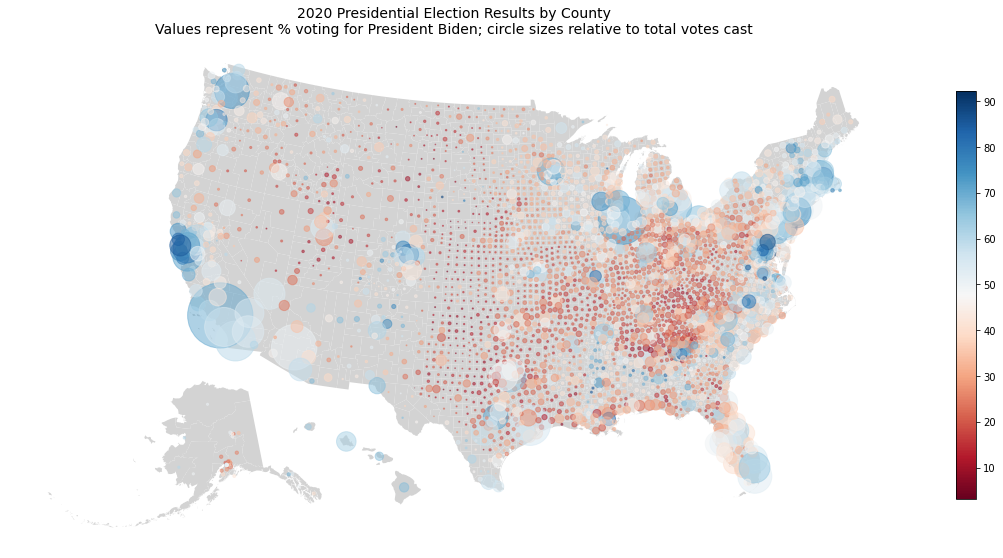

In [11]:
# Get the centroids
centers = us_election_shift.copy()
centers['geometry'] = us_election_shift.centroid
centers['votes_scaled'] = centers['total_votes'] / 1000

# Make the map
fig, ax = plt.subplots(figsize = (20, 15))

us_election_shift.plot(color = "lightgrey", ax = ax, linewidth = 0.1)

centers.plot(markersize = "votes_scaled", column = "per_dem", cmap = "RdBu", 
             k = 7, ax = ax, legend = True, alpha = 0.5, legend_kwds = dict(shrink = 0.5))

ax.set_axis_off()

plt.title("2020 Presidential Election Results by County\nValues represent % voting for President Biden; circle sizes relative to total votes cast",
          fontsize = 14)